#Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#core modeling tools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Task Configurations
TARGET_ARTISTS = [ #6 artists defined
    "Taylor Swift",
    "Drake",
    "The Weeknd",
    "Billie Eilish",
    "Kendrick Lamar",
    "Bad Bunny"
]

N_FUTURE_YEARS = 5  # num of years we forecast into the future
EVAL_HORIZON = 3   # shorter horizon for evaluating forecast accuracy
MIN_TRACKS = 4  # minimum tracks per artist-year - to avoid very sparse artist-year observations and reduce noise



#Load Dataset: Spotify Global Music Dataset (2009-2025)

To analyze fame over time, we rely on track_data_final.csv, which spans 2009–2023

In [ ]:
import kagglehub

path = kagglehub.dataset_download(
    "wardabilal/spotify-global-music-dataset-20092025"
)

df = pd.read_csv(f"{path}/track_data_final.csv")

Using Colab cache for faster access to the 'spotify-global-music-dataset-20092025' dataset.


#Pre-processing and Aggregation
We only are evaluating on the 6 artists mentioned, so we filter out the data that is irrelevant. We also extract the year from release date metrics, to use to aggregate to artist-year level.

In [ ]:
df = df[df["artist_name"].isin(TARGET_ARTISTS)].copy() #filter to our 6 artists

#extract the release year from albun dates to create a time index
df["year"] = pd.to_datetime(
    df["album_release_date"], errors="coerce"
).dt.year

#drop ineligible rows
df = df.dropna(subset=["year", "track_popularity"])

#restrict to valid time window
df = df[df["year"].between(2009, 2023)]

In [ ]:
#aggregate yearly fame
artist_yearly = (
    df
    .groupby(["artist_name", "year"])
    .agg(
        fame_mean=("track_popularity", "mean"),
        fame_median=("track_popularity", "median"),
        n_tracks=("track_name", "count")
    )
    .reset_index()
    .sort_values(["artist_name", "year"])
)

#apply rolling smoothing
artist_yearly["fame_roll3"] = (
    artist_yearly
    .groupby("artist_name")["fame_mean"]
    .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

#Exploratory Analysis: Fame Trends Historically

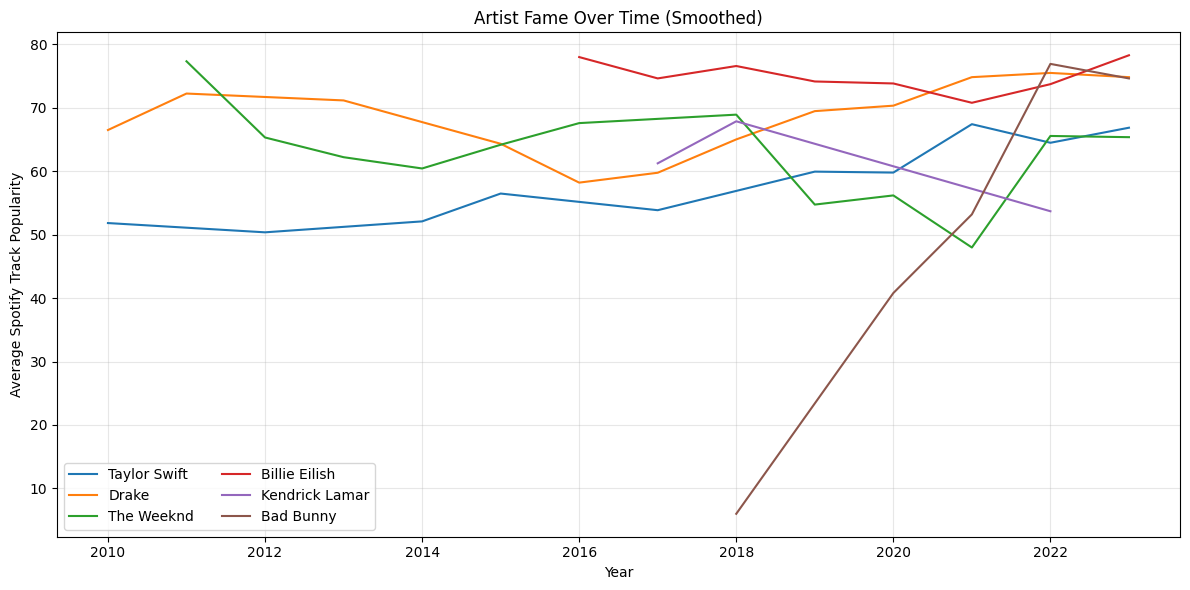

In [ ]:
plt.figure(figsize=(12, 6))

for artist in TARGET_ARTISTS:
    sub = artist_yearly[artist_yearly["artist_name"] == artist]
    plt.plot(sub["year"], sub["fame_roll3"], label=artist)

plt.title("Artist Fame Over Time (Smoothed)")
plt.xlabel("Year")
plt.ylabel("Average Spotify Track Popularity")
plt.legend(ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Baseline Trend Estimation (Ordinary Least Squares)

In [ ]:
trend_rows = []

#estimate a linear trend in fame for each artist
for artist in TARGET_ARTISTS:
    sub = artist_yearly[artist_yearly["artist_name"] == artist]
    if len(sub) < 3: #skip artist if too few observations
        continue

    X = sub[["year"]] #index
    y = sub["fame_mean"] #outcome

    #fit linreg line
    model = LinearRegression().fit(X, y)

    trend_rows.append({
        "artist": artist,
        "trend_slope_per_year": model.coef_[0],
        "r2": model.score(X, y)
    })

trend_df = pd.DataFrame(trend_rows)
trend_df


,artist,trend_slope_per_year,r2
0,Taylor Swift,1.519085,0.414090
1,Drake,0.649352,0.087459
2,The Weeknd,-0.192010,0.002512
3,Billie Eilish,0.658972,0.089382
4,Kendrick Lamar,-8.642857,0.807987
5,Bad Bunny,12.305993,0.582389


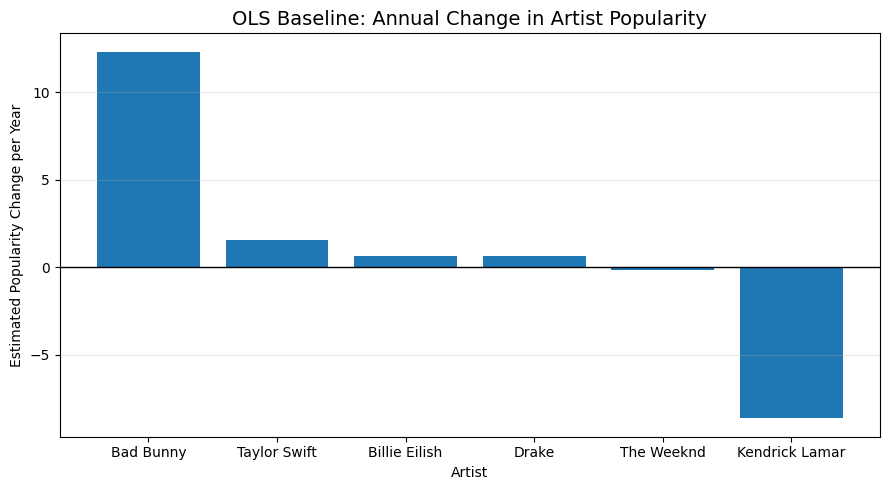

In [ ]:
#visualization
plt.figure(figsize=(9, 5))

trend_df_sorted = trend_df.sort_values("trend_slope_per_year", ascending=False)

plt.bar(
    trend_df_sorted["artist"],
    trend_df_sorted["trend_slope_per_year"]
)

plt.axhline(0, color="black", linewidth=1)
plt.title("OLS Baseline: Annual Change in Artist Popularity", fontsize=14)
plt.ylabel("Estimated Popularity Change per Year")
plt.xlabel("Artist")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Historical Fame Spike Detection
A spike is defined as: a year is a spike if it is in the top 10% of the artists historical popularity


In [ ]:
artist_yearly["is_spike"] = False

for artist in TARGET_ARTISTS:
    sub = artist_yearly[artist_yearly["artist_name"] == artist]
    threshold = sub["fame_mean"].quantile(0.90) #defined spike threshold
    artist_yearly.loc[sub.index, "is_spike"] = sub["fame_mean"] >= threshold

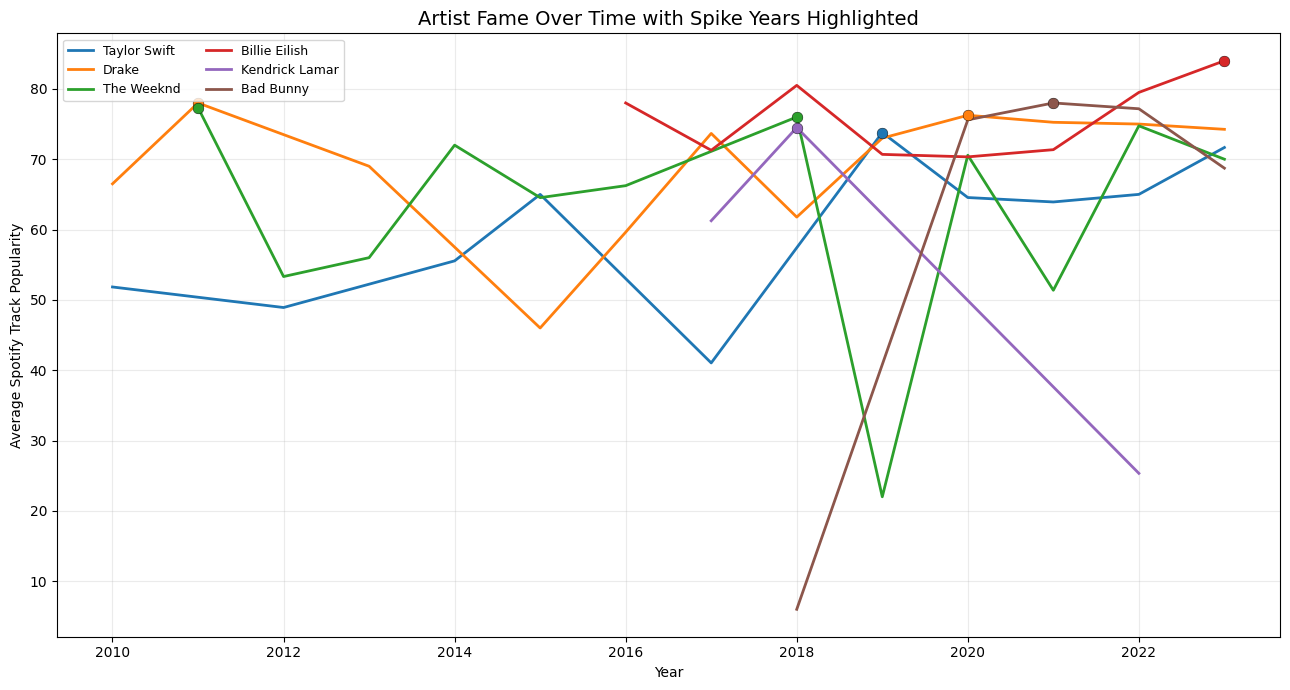

In [ ]:
#time series plot with spike years highlighted
plt.figure(figsize=(13, 7))

colors = plt.cm.tab10.colors
artist_colors = dict(zip(TARGET_ARTISTS, colors))

for artist in TARGET_ARTISTS:
    sub = artist_yearly[artist_yearly["artist_name"] == artist]

    # Fame over time (line)
    plt.plot(
        sub["year"],
        sub["fame_mean"],
        color=artist_colors[artist],
        linewidth=2,
        label=artist
    )

    # Spike years (dots, same color as line)
    spikes = sub[sub["is_spike"]]
    if not spikes.empty:
        plt.scatter(
            spikes["year"],
            spikes["fame_mean"],
            color=artist_colors[artist],
            s=60,
            edgecolor="black",
            linewidth=0.3,
            zorder=5
        )

plt.title("Artist Fame Over Time with Spike Years Highlighted", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Average Spotify Track Popularity")

plt.legend(fontsize=9, ncol=2)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()



In [ ]:
spike_years = artist_yearly[artist_yearly["is_spike"]].copy()
spikes_with_tracks = []

for _, row in spike_years.iterrows():
    artist = row["artist_name"]
    year = row["year"]

    top_tracks = (
        df[(df["artist_name"] == artist) & (df["year"] == year)]
        .sort_values("track_popularity", ascending=False)
        .head(5)["track_name"]
        .tolist()
    )

    spikes_with_tracks.append({
        "artist": artist,
        "year": year,
        "fame_mean": row["fame_mean"],
        "top_tracks": top_tracks
    })

spikes_df = pd.DataFrame(spikes_with_tracks)
display(spikes_df)


,artist,year,fame_mean,top_tracks
0,Bad Bunny,2021.0,78.000000,[Yonaguni]
1,Billie Eilish,2023.0,84.000000,[What Was I Made For? [From The Motion Picture...
2,Drake,2011.0,78.000000,"[Headlines, Practice, Take Care, The Motto]"
3,Drake,2020.0,76.250000,"[Not You Too (feat. Chris Brown), Chicago Free..."
4,Kendrick Lamar,2018.0,74.500000,"[All The Stars (with SZA) - From ""Black Panthe..."
5,Taylor Swift,2019.0,73.789474,"[Cruel Summer, Lover, Daylight, False God, Mis..."
6,The Weeknd,2011.0,77.333333,"[House Of Balloons / Glass Table Girls, The Pa..."
7,The Weeknd,2018.0,76.000000,"[Call Out My Name, I Was Never There, Hurt You..."


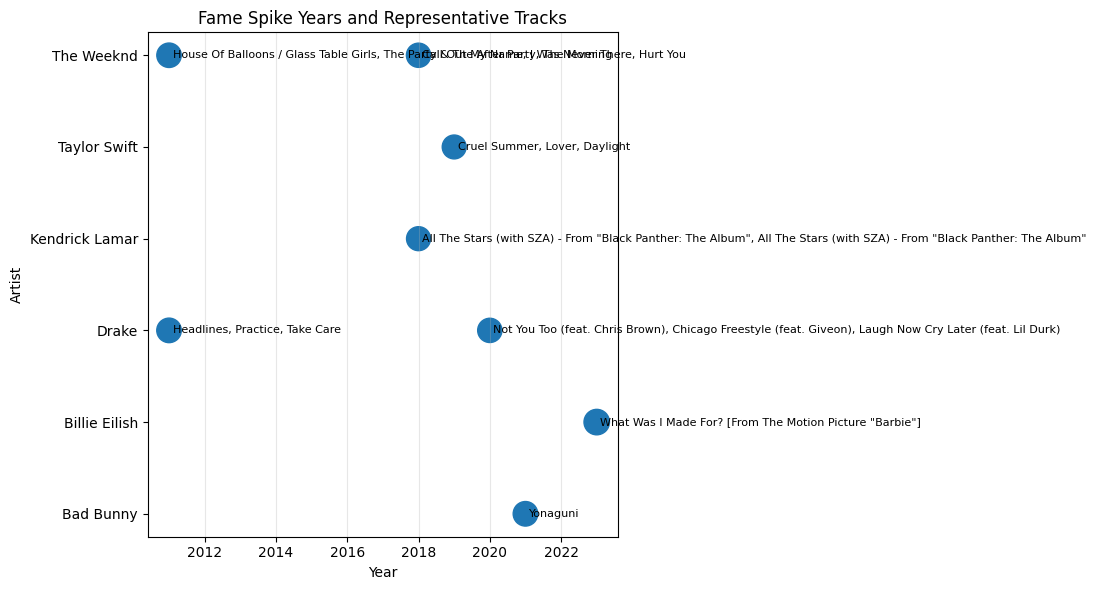

In [ ]:
#spike summary table
spikes_df["top_tracks_str"] = spikes_df["top_tracks"].apply(
    lambda x: ", ".join(x[:3])
)
plt.figure(figsize=(10, 6))

plt.scatter(
    spikes_df["year"],
    spikes_df["artist"],
    s=spikes_df["fame_mean"] * 4,  # size = spike strength
)

for _, row in spikes_df.iterrows():
    plt.text(
        row["year"] + 0.1,
        row["artist"],
        row["top_tracks_str"],
        fontsize=8,
        va="center"
    )

plt.title("Fame Spike Years and Representative Tracks")
plt.xlabel("Year")
plt.ylabel("Artist")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


#Time series forecasting with SARIMAX

Note: SARIMAX needs enough history to estimate autoregressive terms, moving average terms, and integration. Forcasting for artists in the dataset with only newer data (Bad Bunny and Kendrick Lamar) did not work well because there wasn't enough historical data to support time-series modeling.




Evaluation (Hold-out MAE) was performed only for artists with sufficient historical data in the dataset.

In [ ]:
eval_rows = []

#evaluate short-horizon forecast accuracy for each artist
for artist in TARGET_ARTISTS:
    ts = (
        artist_yearly[artist_yearly["artist_name"] == artist]
        .set_index("year")["fame_mean"]
        .sort_index()
    )

    if len(ts) < 8: #skip artists without enough history for a meaningful split
        continue

    train = ts.iloc[:-EVAL_HORIZON]
    test = ts.iloc[-EVAL_HORIZON:] #last few years as eval

    #fit sarimax model
    model = SARIMAX(
        train,
        order=(1, 1, 1),
        trend="c",
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    res = model.fit(disp=False) #compare to reality
    preds = res.forecast(steps=EVAL_HORIZON)

    #store mean absolute error
    eval_rows.append({
        "artist": artist,
        "MAE_holdout_3yr": mean_absolute_error(test, preds)
    })

forecast_eval_df = pd.DataFrame(eval_rows)
forecast_eval_df


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

,artist,MAE_holdout_3yr
0,Taylor Swift,12.368183
1,Drake,2.002503
2,The Weeknd,14.927735
3,Billie Eilish,19.256491


## Final Forecasts (5 years)

In [ ]:
forecast_rows = []

#generate multi-year popularity forecast for each artist
for artist in TARGET_ARTISTS:
    ts = (
        artist_yearly[artist_yearly["artist_name"] == artist]
        .set_index("year")["fame_mean"]
        .sort_index()
    )

    if len(ts) < 6:
        continue

    model = SARIMAX(
        ts,
        order=(1, 1, 1),
        trend="c",
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    res = model.fit(disp=False)
    preds = res.forecast(steps=N_FUTURE_YEARS)

    last_year = ts.index.max()

    for i, val in enumerate(preds, start=1):
        forecast_rows.append({
            "artist": artist,
            "year": last_year + i,
            "fame_forecast": float(val)
        })

forecast_df = pd.DataFrame(forecast_rows)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

## Bad Bunny and Kendrick Alternative Approach: Pooled time-series forecasting with artist-specific intercepts
Due to lack of coverage in the dataset, we decided to try an alternative approach for Bad Bunny and Kendric Lamar

In [ ]:
#evidence of lack of data coverage:
artist_yearly[artist_yearly["artist_name"]=="Kendrick Lamar"][["year","fame_mean","n_tracks"]]
artist_yearly[artist_yearly["artist_name"]=="Bad Bunny"][["year","fame_mean","n_tracks"]]
#kendrick has very sparse data, bad bunny has a sudden explosion of recent data


,year,fame_mean,n_tracks
0,2018.0,6.000000,1
1,2020.0,75.600000,5
2,2021.0,78.000000,1
3,2022.0,77.173913,23
4,2023.0,68.727273,22


### Filter low-coverage years

In [ ]:
artist_yearly_filtered = artist_yearly[
    artist_yearly["n_tracks"] >= MIN_TRACKS
].copy()


### Build pooled dataset

In [ ]:
POOLED_ARTISTS = ["Kendrick Lamar", "Bad Bunny"] #artists with sparse histories are pooled to share time-series dynamics


#stack observations from both artists into a single dataset
pooled = (
    artist_yearly_filtered[
        artist_yearly_filtered["artist_name"].isin(POOLED_ARTISTS)
    ]
    .sort_values(["artist_name", "year"])
    .reset_index(drop=True)
)

y = pooled["fame_mean"]

#set different average levels for each artist but share dynamics
X = pd.get_dummies(pooled["artist_name"], drop_first=True).astype(int)


### Fit pooled SARIMAX

In [ ]:
pooled_model = SARIMAX(
    y,
    exog=X,
    order=(0, 1, 1),
    trend=None,
    enforce_stationarity=False,
    enforce_invertibility=False
)

pooled_res = pooled_model.fit(disp=False)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecast pooled artists (Bad Bunny, Kendrick Lamar)

In [ ]:
last_year = pooled["year"].max()
future_years = [last_year + i for i in range(1, N_FUTURE_YEARS + 1)]

future_rows = [
    {"artist": a, "year": y}
    for a in POOLED_ARTISTS
    for y in future_years
]

future_df = pd.DataFrame(future_rows)

future_exog = pd.get_dummies(
    future_df["artist"], drop_first=True
).astype(int)

future_exog = future_exog.reindex(columns=X.columns, fill_value=0)

future_df["fame_forecast"] = pooled_res.forecast(
    steps=len(future_df),
    exog=future_exog
).values


## Combined All Forecasts

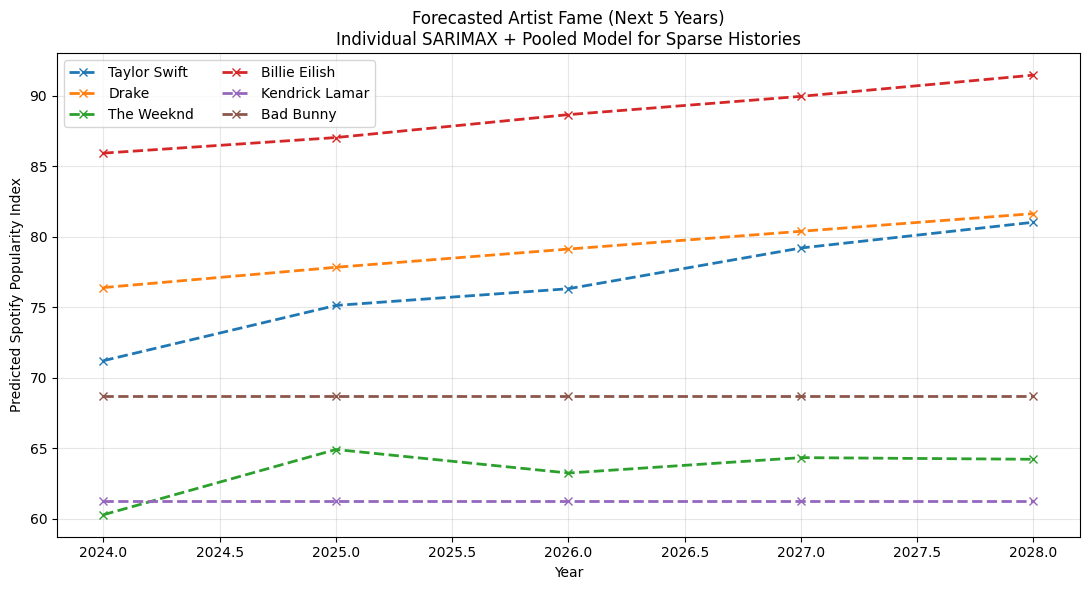

In [ ]:
combined_forecast_df = pd.concat(
    [forecast_df, future_df],
    ignore_index=True
)

combined_forecast_df


plt.figure(figsize=(11, 6))

colors = plt.cm.tab10.colors
artist_colors = dict(zip(TARGET_ARTISTS, colors))

for artist in TARGET_ARTISTS:
    sub = combined_forecast_df[
        combined_forecast_df["artist"] == artist
    ]
    if sub.empty:
        continue

    plt.plot(
        sub["year"],
        sub["fame_forecast"],
        marker="x",
        linestyle="--",
        linewidth=2,
        color=artist_colors[artist],
        label=artist
    )

plt.title(
    "Forecasted Artist Fame (Next 5 Years)\n"
    "Individual SARIMAX + Pooled Model for Sparse Histories"
)
plt.xlabel("Year")
plt.ylabel("Predicted Spotify Popularity Index")
plt.legend(ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Who is predicted to be most popular in each future year?



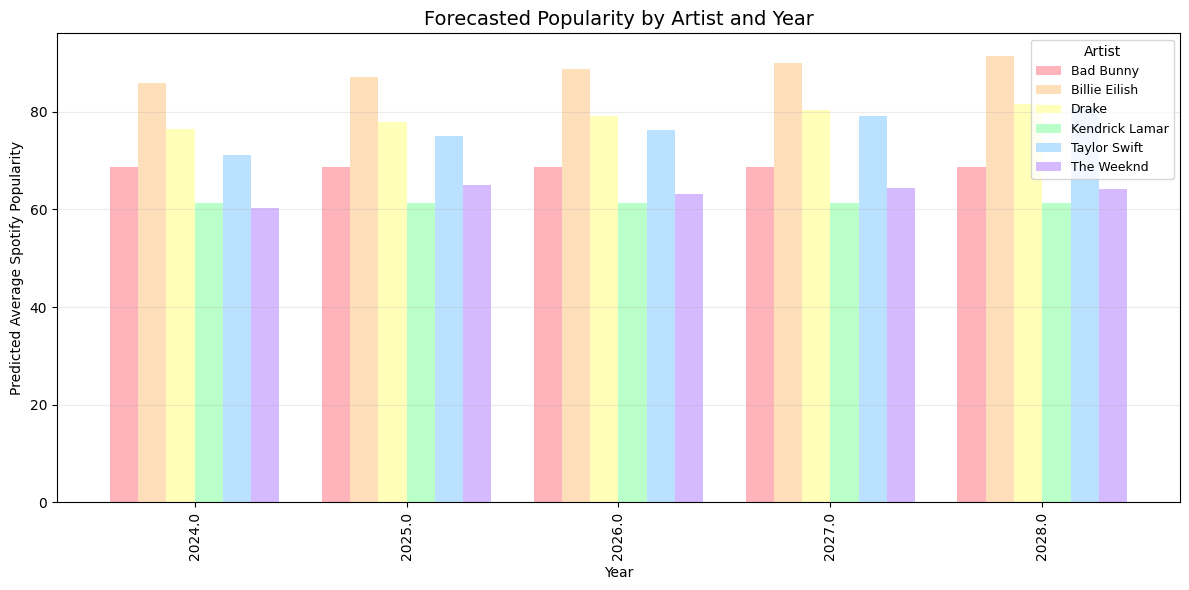

In [ ]:
import matplotlib.pyplot as plt

pivot = combined_forecast_df.pivot(
    index="year",
    columns="artist",
    values="fame_forecast"
)

colors=  [
    "#FFB3BA",
    "#FFDFBA",
    "#FFFFBA",
    "#BAFFC9",
    "#BAE1FF",
    "#D5BAFF"
]
artist_order = list(pivot.columns)

ax = pivot.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8,
    color=colors[:len(artist_order)]
)

plt.title("Forecasted Popularity by Artist and Year", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Predicted Average Spotify Popularity")

plt.legend(title="Artist", fontsize=9)
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

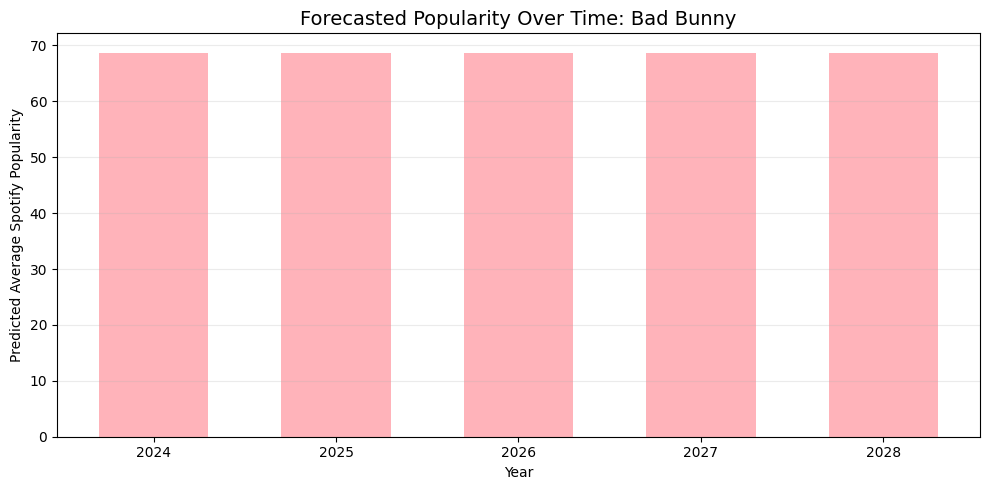

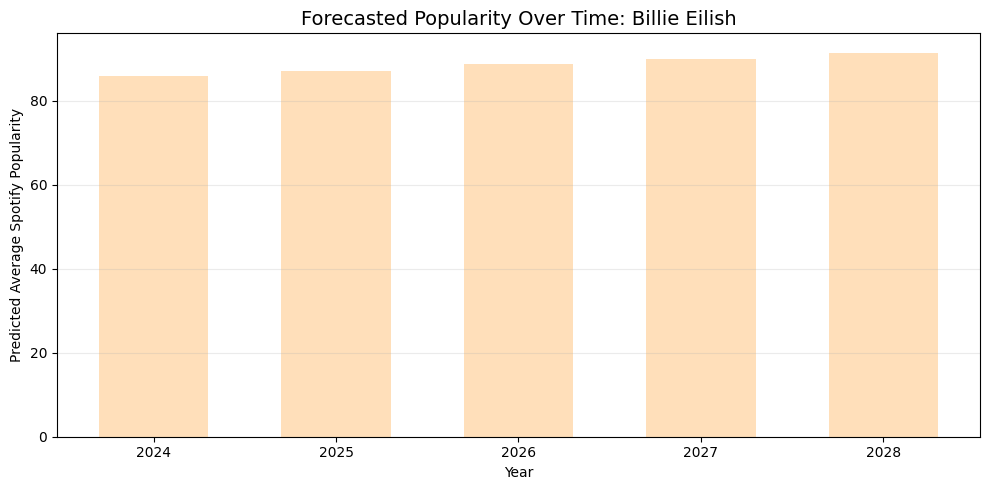

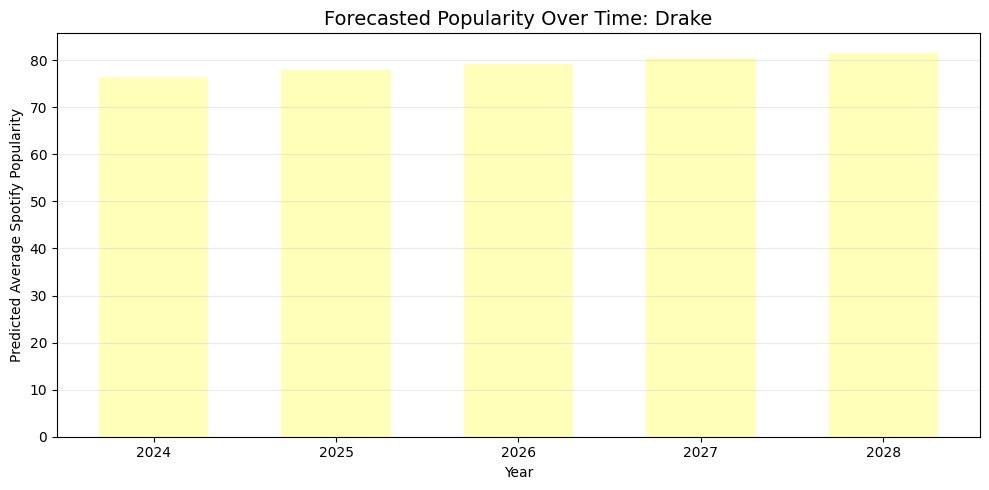

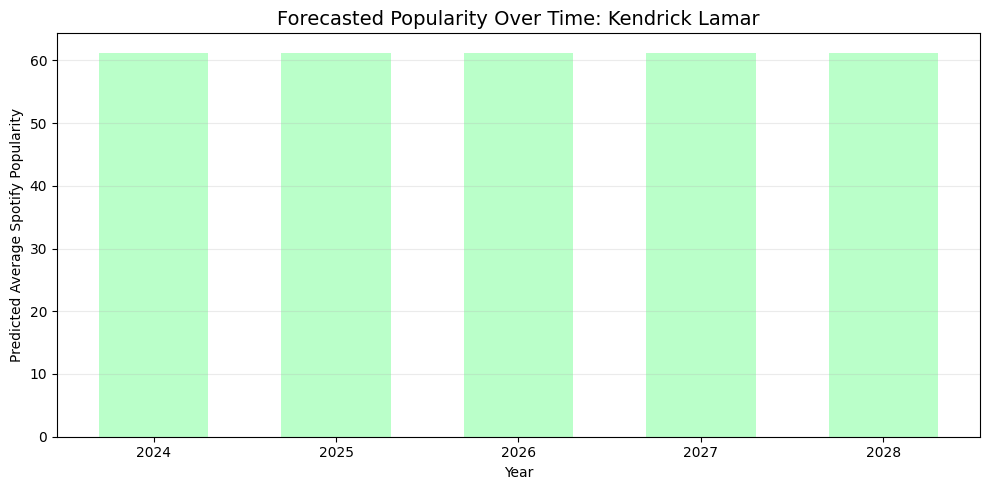

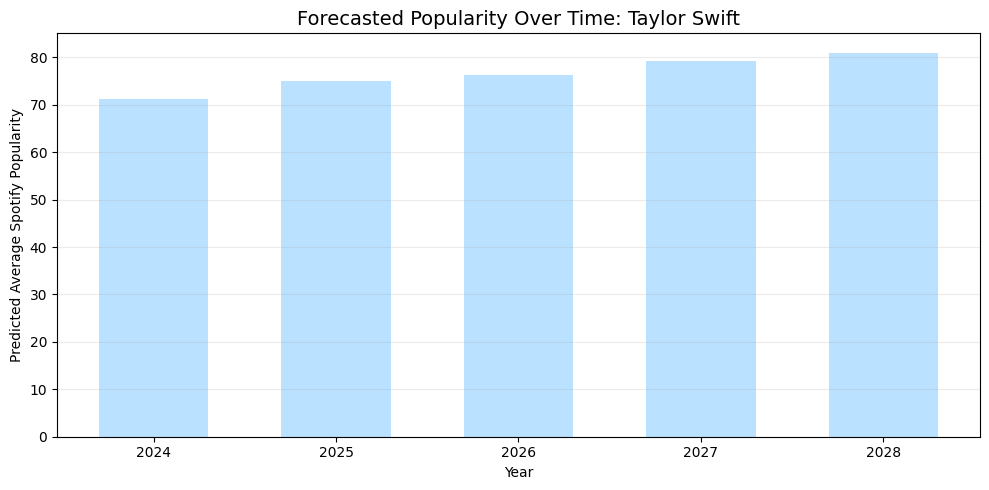

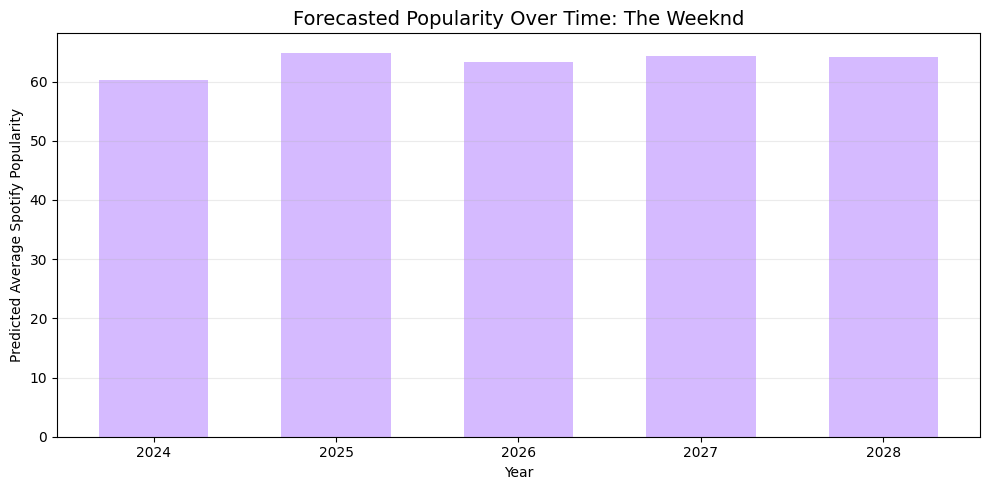

In [ ]:
import matplotlib.pyplot as plt

# Pivot
pivot = combined_forecast_df.pivot(
    index="year",
    columns="artist",
    values="fame_forecast"
)

colors = [
    "#FFB3BA",
    "#FFDFBA",
    "#FFFFBA",
    "#BAFFC9",
    "#BAE1FF",
    "#D5BAFF"
]

artist_order = list(pivot.columns)
artist_color_map = dict(zip(artist_order, colors))

# One figure per artist
for artist in artist_order:
    plt.figure(figsize=(10, 5))

    plt.bar(
        pivot.index,
        pivot[artist],
        color=artist_color_map[artist],
        width=0.6
    )

    plt.title(f"Forecasted Popularity Over Time: {artist}", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Predicted Average Spotify Popularity")
    plt.grid(axis="y", alpha=0.25)

    plt.tight_layout()
    plt.show()


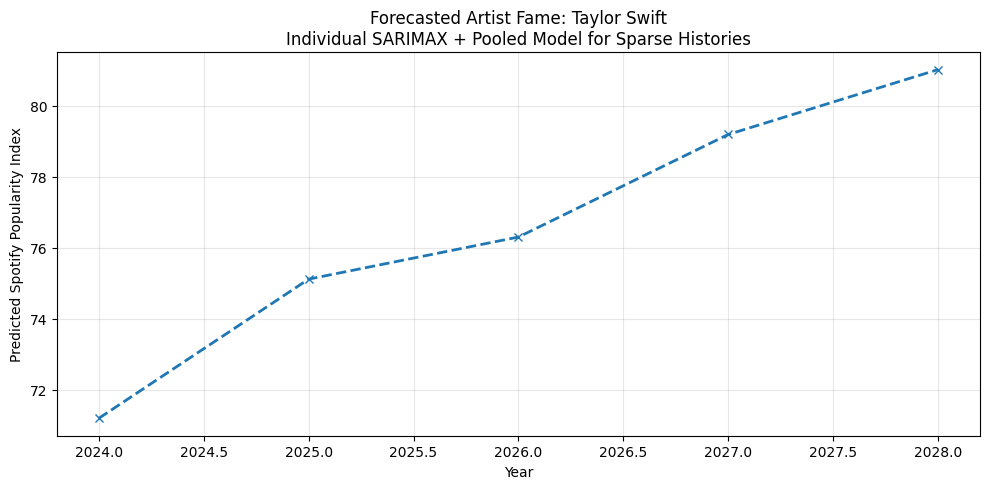

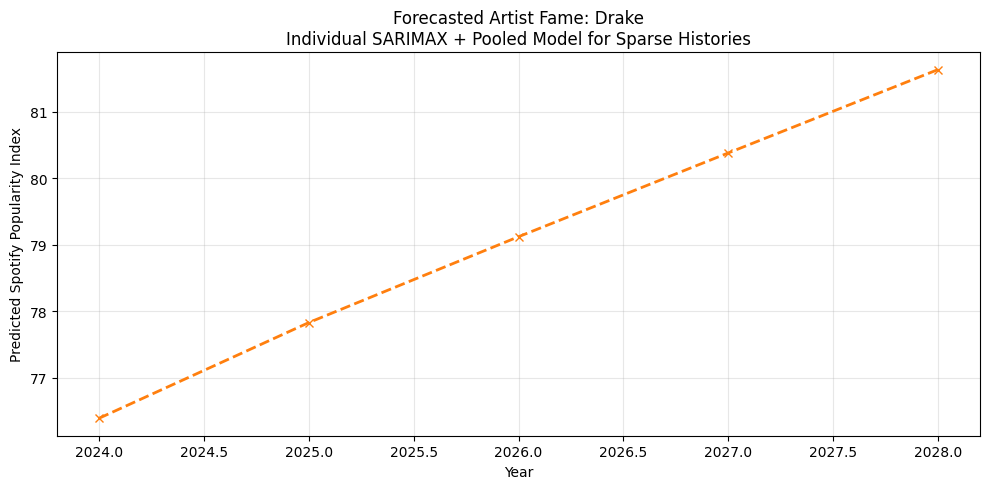

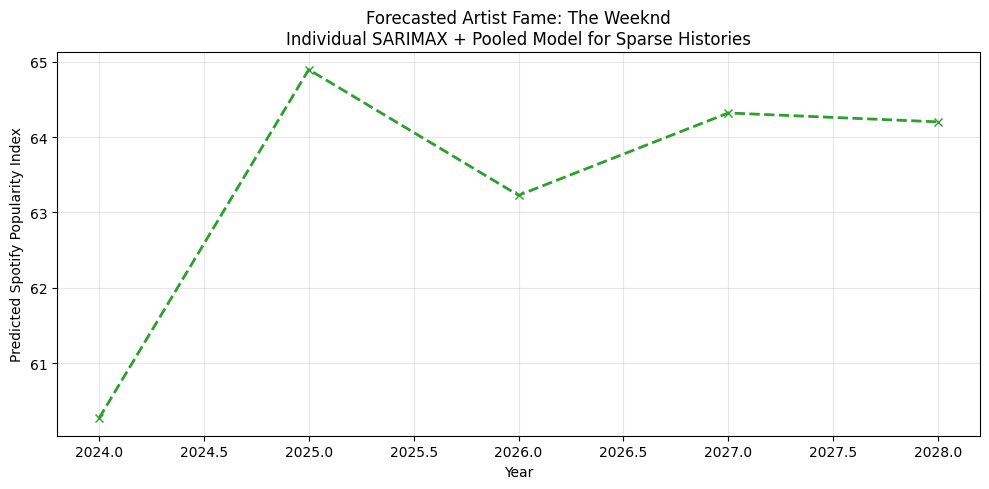

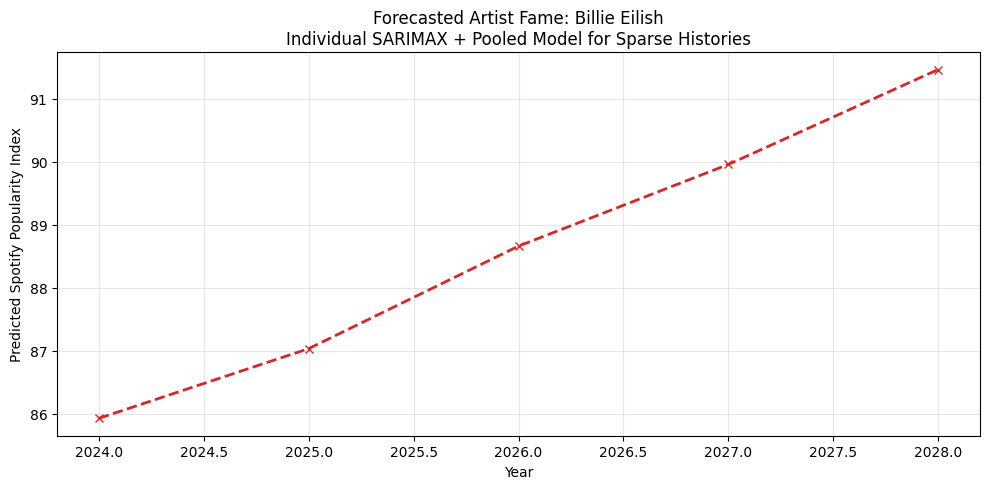

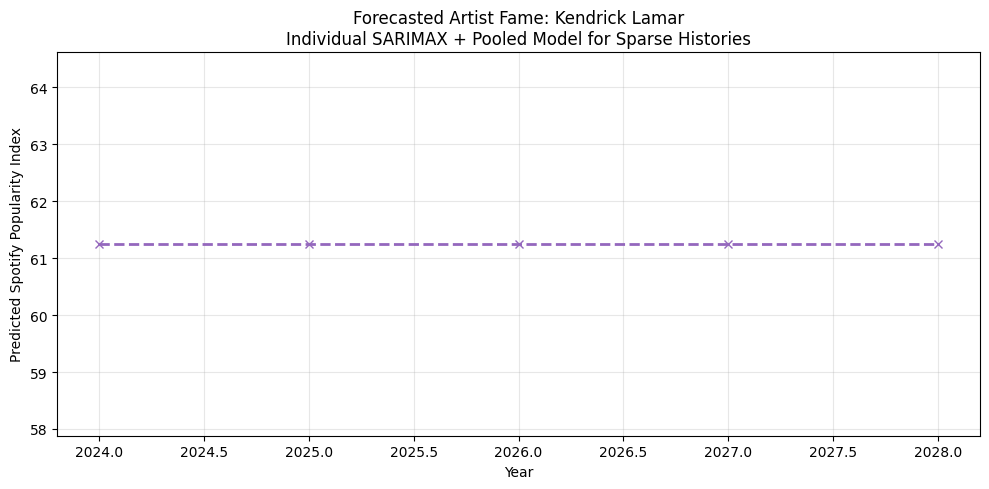

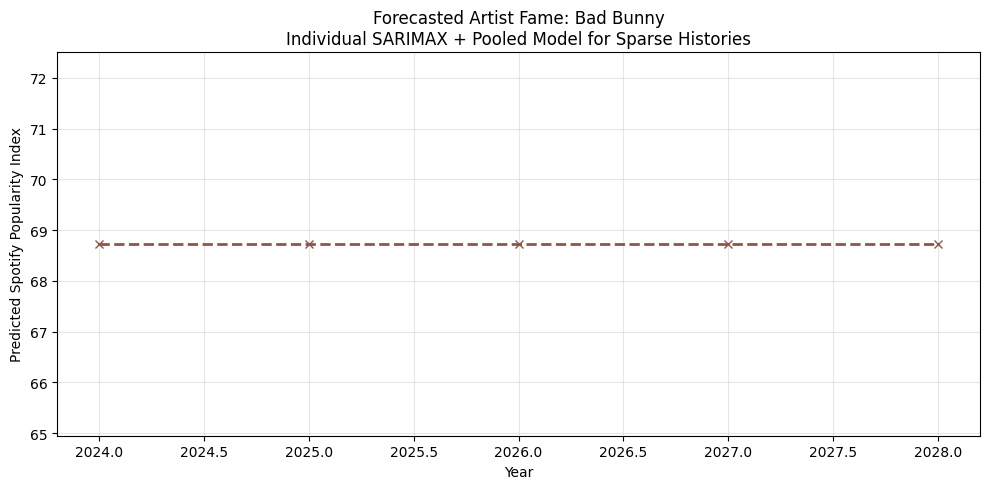

In [ ]:
import matplotlib.pyplot as plt

# Combine forecasts
combined_forecast_df = pd.concat(
    [forecast_df, future_df],
    ignore_index=True
)

# Same color mapping as before
colors = plt.cm.tab10.colors
artist_colors = dict(zip(TARGET_ARTISTS, colors))

# One figure per artist
for artist in TARGET_ARTISTS:
    sub = combined_forecast_df[
        combined_forecast_df["artist"] == artist
    ]
    if sub.empty:
        continue

    plt.figure(figsize=(10, 5))

    plt.plot(
        sub["year"],
        sub["fame_forecast"],
        marker="x",
        linestyle="--",
        linewidth=2,
        color=artist_colors[artist]
    )

    plt.title(
        f"Forecasted Artist Fame: {artist}\n"
        "Individual SARIMAX + Pooled Model for Sparse Histories"
    )
    plt.xlabel("Year")
    plt.ylabel("Predicted Spotify Popularity Index")
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
